# Visualize Networkss

In [26]:
# Mathematical and Data Managment
import numpy as np
import pandas as pd
import scipy.sparse as sp

# Graph Managment
import graph_tool.all as gt
import networkx as nx
from utils.subutils.Functions import *
from utils.Segregation import *

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from fa2.forceatlas2 import ForceAtlas2

# Miscellaneous
from glob import glob
from tqdm import tqdm
import random
import time
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from datetime import datetime, timedelta

random.seed(2)

# Create ForceAtlas2 object with desired parameters
forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=True,  # Dissuade hubs
                          linLogMode=False,  # NOT IMPLEMENTED
                          adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                          edgeWeightInfluence=1.0,

                          # Performance
                          jitterTolerance=1.0,  # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=1.2,
                          multiThreaded=False,  # NOT IMPLEMENTED

                          # Tuning
                          scalingRatio=2.0,
                          strongGravityMode=True,
                          gravity=1.0,

                          # Log
                          verbose=True)

### Testing the package

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:13<00:00, 363.35it/s]


BarnesHut Approximation  took  10.24  seconds
Repulsion forces  took  2.74  seconds
Gravitational forces  took  0.02  seconds
Attraction forces  took  0.10  seconds
AdjustSpeedAndApplyForces step  took  0.05  seconds


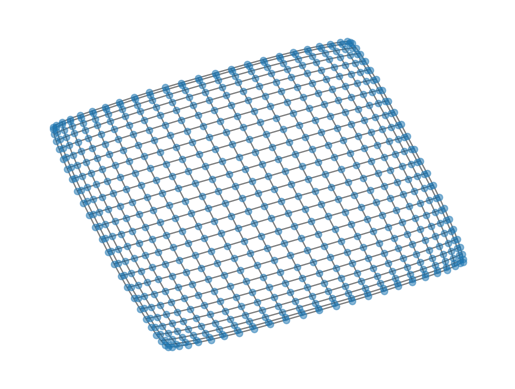

In [3]:
G = nx.grid_2d_graph(25, 25)
positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=5000)
nx.draw_networkx(G, positions, node_size=20, with_labels=False, alpha=0.5)
plt.axis('off')
plt.show()

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:03<00:00, 664.48it/s]


BarnesHut Approximation  took  1.74  seconds
Repulsion forces  took  0.82  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.27  seconds
AdjustSpeedAndApplyForces step  took  0.01  seconds


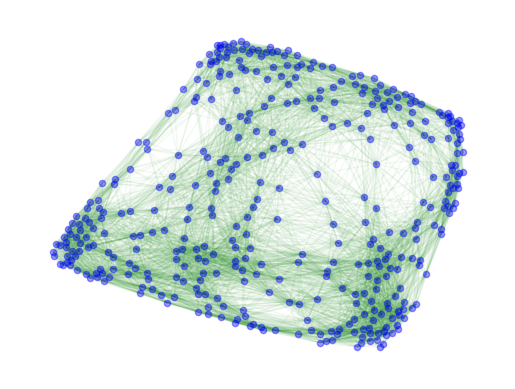

In [5]:
G = nx.random_geometric_graph(400, 0.2)
positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)
nx.draw_networkx_nodes(G, positions, node_size=20, node_color="blue", alpha=0.4)
nx.draw_networkx_edges(G, positions, edge_color="green", alpha=0.05)
plt.axis('off')
plt.show()

100%|██████████| 10000/10000 [00:00<00:00, 202152.67it/s]

BarnesHut Approximation  took  0.01  seconds
Repulsion forces  took  0.01  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.00  seconds


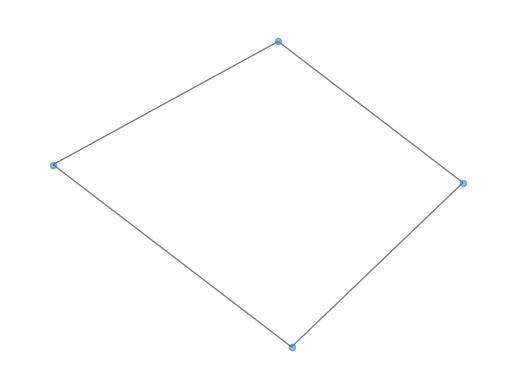

In [5]:
# run forceatlas2
G = np.array([[0, 1, 0, 1], [1, 0, 1, 0], [0, 1, 0, 1], [1, 0, 1, 0]]) # simple 2x2 grid graph
positions = forceatlas2.forceatlas2(G, pos=None, iterations=10000)

# To plot the graph
networkx_graph = nx.from_numpy_array(G)
nx.draw_networkx(networkx_graph, positions, node_size=20, with_labels=False, alpha=0.5)
plt.axis('off')
plt.show()

100%|██████████| 2000/2000 [00:00<00:00, 7768.35it/s]


BarnesHut Approximation  took  0.09  seconds
Repulsion forces  took  0.11  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.02  seconds
AdjustSpeedAndApplyForces step  took  0.00  seconds


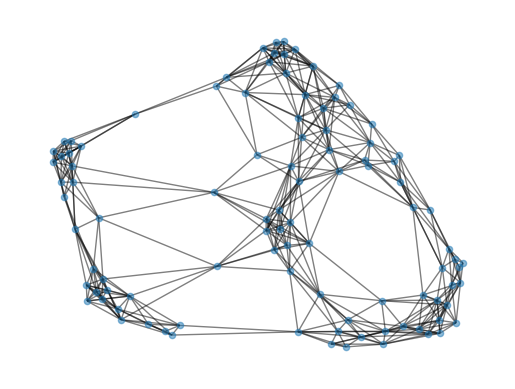

In [6]:
import igraph

# Construct an iGraph
G = nx.random_geometric_graph(100, 0.2)
iG = igraph.Graph.TupleList(G.edges(), directed=False) # converting to iGraph
iG.es['weight'] = np.random.randint(low=1, high=10, size=len(G.edges())) # set random edge weights

# run forceatlas2 on iGraph
layout = forceatlas2.forceatlas2_igraph_layout(iG, pos=None, iterations=2000, weight_attr='weight')

# plot iGraph (using Networkx or you can use iGraph plot func too)
nxG = nx.Graph(iG.get_edgelist())
positions = layout.coords
nx.draw_networkx(nxG, positions, node_size=20, with_labels=False, alpha=0.5)
plt.axis('off')
plt.show()

In [27]:
# Load the graph
test_file = "/mnt/disk2/Data/3_Day_Graphs/starting_2021-05-03.graphml"

# Load Grap
g = gt.load_graph(test_file)

g.set_directed(False)
g_nx = to_networkx(g)

date = test_file.split('.')[-2].split('/')[-1].split('_')[1]

In [28]:
# Get rid of self loops
g_nx.remove_edges_from(nx.selfloop_edges(g_nx))

# Find Largest Component
largest_cc = max(nx.connected_components(g_nx), key=len)

# Create a subgraph from the combined components
subgraph = g_nx.subgraph(largest_cc)

In [16]:
print('Grafo Completo NO dirigido')
print(g_nx)
print('-'*20)
print('Sub Grafo Comoponente más grande')
print(subgraph)

Grafo Completo NO dirigido
Graph with 36964 nodes and 713065 edges
--------------------
Sub Grafo Comoponente más grande
Graph with 32770 nodes and 713041 edges


In [43]:
positions_df = pd.read_csv('/home/fcastrillon/Data/3_Day_Graphs/positions.csv', sep=';')
gephi_pos = {i.Id: (i.X, i.Y) for i in positions_df.itertuples()}

In [29]:
print('Layout Grafo Completo:', g_nx)
layout_g_nx = forceatlas2.forceatlas2_networkx_layout(g_nx, pos=None, iterations=200)
print('')
print('Layout Componente más grande:', subgraph)
layout_subgraph = forceatlas2.forceatlas2_networkx_layout(subgraph, pos=layout_g_nx, iterations=200)

Layout Grafo Completo: Graph with 36964 nodes and 713065 edges


100%|██████████| 200/200 [02:32<00:00,  1.31it/s]


BarnesHut Approximation  took  108.99  seconds
Repulsion forces  took  38.80  seconds
Gravitational forces  took  0.05  seconds
Attraction forces  took  3.46  seconds
AdjustSpeedAndApplyForces step  took  0.11  seconds

Layout Componente más grande: Graph with 32770 nodes and 713041 edges


100%|██████████| 200/200 [02:07<00:00,  1.57it/s]

BarnesHut Approximation  took  93.29  seconds
Repulsion forces  took  29.72  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  3.31  seconds
AdjustSpeedAndApplyForces step  took  0.10  seconds


# Force Atlas 2 using Networkx Package

## all the graph

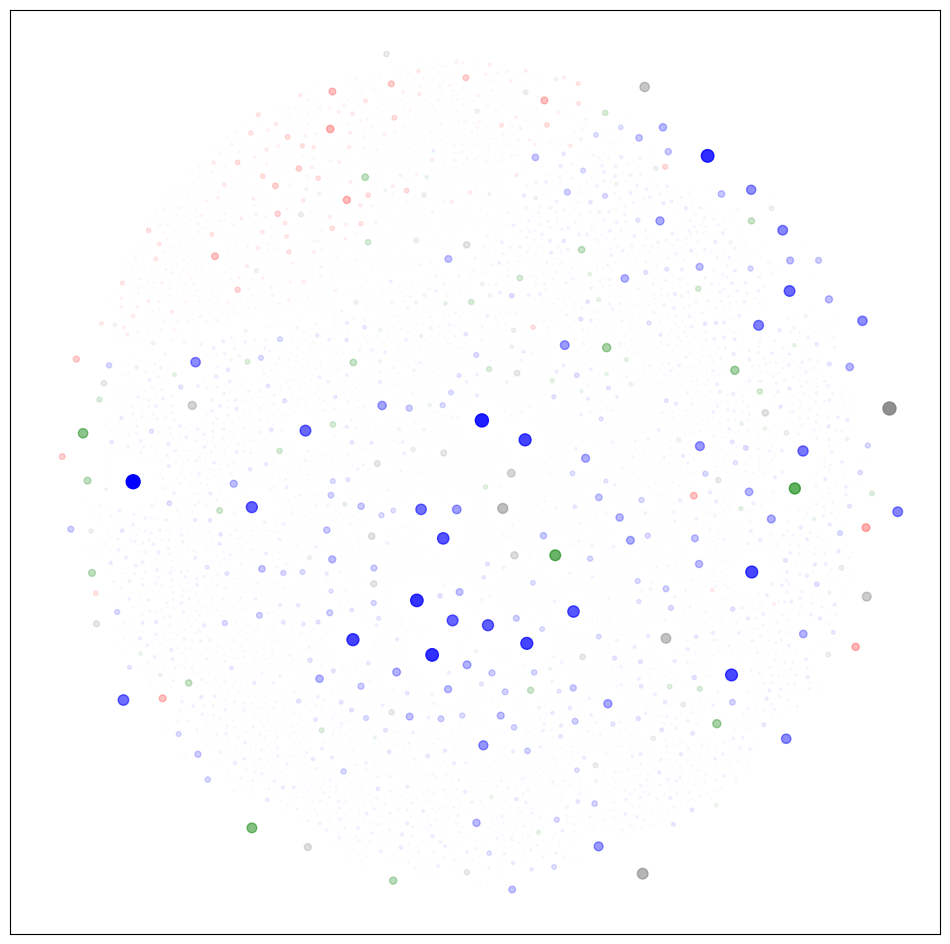

In [30]:
# Color
color_map_dict = {
    'No Retweets': 'gray',
    'Izquierda': 'blue',
    'Derecha': 'red',
    'Centro': 'green'
}
color_map_node = [color_map_dict[g_nx.nodes[node]['Political Label']] for node in g_nx]
color_edge_map = [color_map_dict[g_nx.nodes(data=True)[edge[1]]['Political Label']] for edge in list(g_nx.edges(data=True))]

# Alpha
degrees = dict(g_nx.degree())
max_degree = max(degrees.values())
alpha_values = [(degree / max_degree) for degree in degrees.values()]

# Size
node_degrees = [g_nx.degree(node) * 100 for node in g_nx.nodes()]
def normalize(x, max, min):
    return 100 * ((x - min)/(max - min))
max_deg = max(node_degrees)
min_deg = min(node_degrees)
node_size = list(map(lambda x: normalize(x, max_deg, min_deg), node_degrees))

fig, ax = plt.subplots(figsize = (12,12))

nx.draw_networkx_nodes(g_nx, layout_g_nx, node_color = color_map_node, node_size = node_size, ax = ax, alpha = alpha_values)
#nx.draw_networkx_edges(g_nx, layout, edge_color=color_edge_map, alpha = 0.01)
plt.show()

## All the Graph but with colored edges

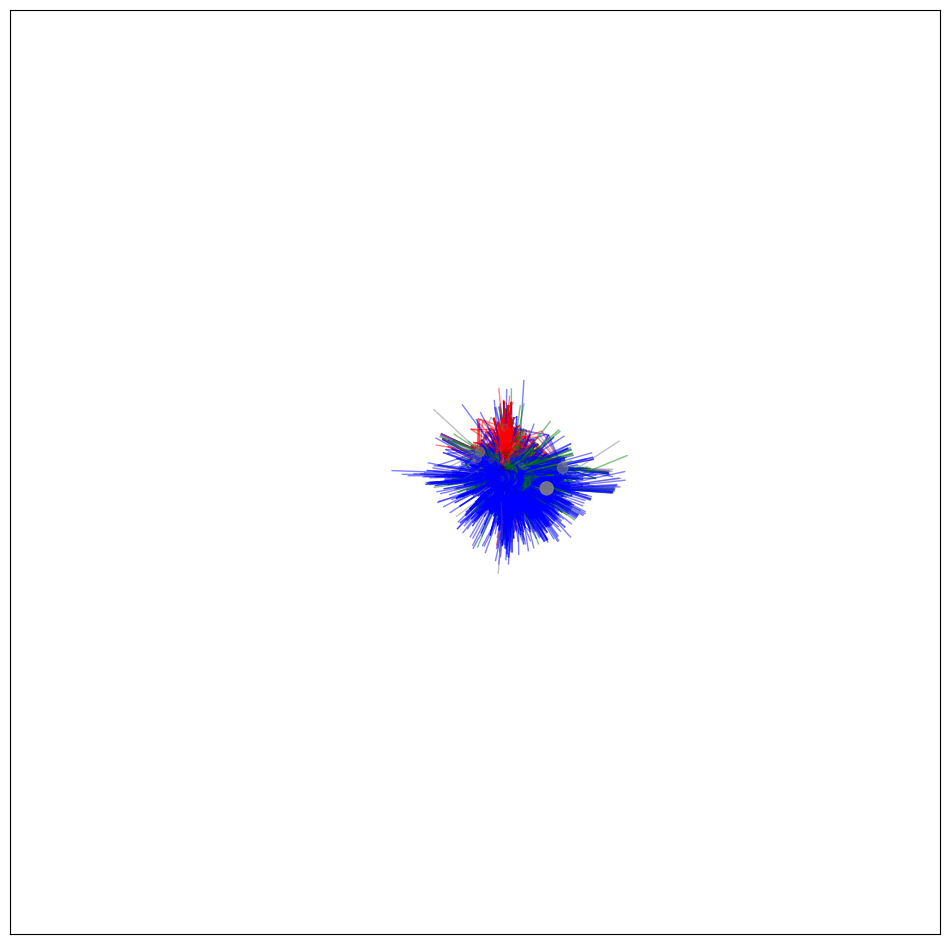

In [20]:
# Color
color_map_dict = {
    'No Retweets': 'gray',
    'Izquierda': 'blue',
    'Derecha': 'red',
    'Centro': 'green'
}
color_map_node = [color_map_dict[g_nx.nodes[node]['Political Label']] for node in g_nx]
color_edge_map = [color_map_dict[g_nx.nodes(data=True)[edge[1]]['Political Label']] for edge in list(g_nx.edges(data=True))]

# Alpha
degrees = dict(g_nx.degree())
max_degree = max(degrees.values())
alpha_values = [(degree / max_degree) for degree in degrees.values()]

# Size
node_degrees = [g_nx.degree(node) * 100 for node in g_nx.nodes()]
def normalize(x, max, min):
    return 100 * ((x - min)/(max - min))
max_deg = max(node_degrees)
min_deg = min(node_degrees)
node_size = list(map(lambda x: normalize(x, max_deg, min_deg), node_degrees))

fig, ax = plt.subplots(figsize = (12,12))

nx.draw_networkx_nodes(g_nx, layout_g_nx, node_color = color_map_node, node_size = node_size, ax = ax, alpha = alpha_values)
nx.draw_networkx_edges(g_nx, layout_g_nx, edge_color=color_edge_map, alpha=0.003)
plt.show()

## Biggest Component

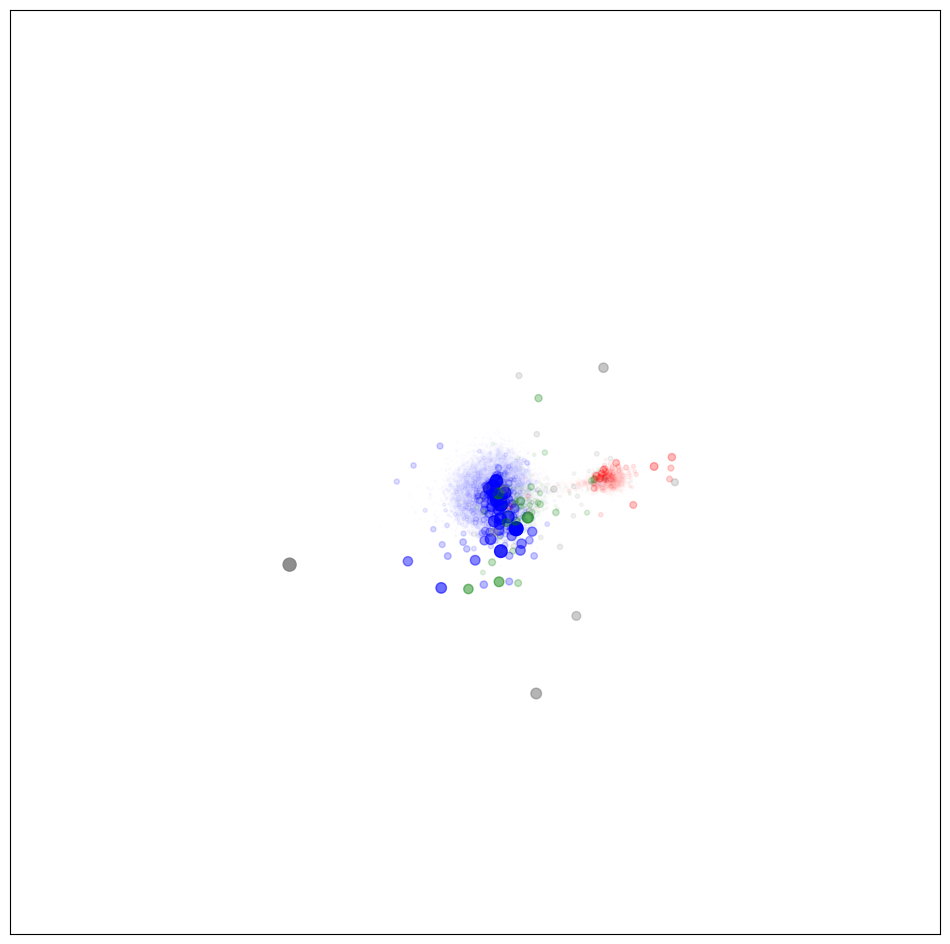

In [21]:
# Color
color_map_dict = {
    'No Retweets': 'gray',
    'Izquierda': 'blue',
    'Derecha': 'red',
    'Centro': 'green'
}
color_map_node = [color_map_dict[subgraph.nodes[node]['Political Label']] for node in subgraph]
color_edge_map = [color_map_dict[subgraph.nodes(data=True)[edge[1]]['Political Label']] for edge in list(subgraph.edges(data=True))]

# Alpha
degrees = dict(subgraph.degree())
max_degree = max(degrees.values())
alpha_values = [(degree / max_degree) for degree in degrees.values()]

# Size
node_degrees = [subgraph.degree(node) * 100 for node in subgraph.nodes()]
def normalize(x, max, min):
    return 100 * ((x - min)/(max - min))
max_deg = max(node_degrees)
min_deg = min(node_degrees)
node_size = list(map(lambda x: normalize(x, max_deg, min_deg), node_degrees))

fig, ax = plt.subplots(figsize = (12,12))

nx.draw_networkx_nodes(subgraph, layout_subgraph, node_color = color_map_node, node_size = node_size, ax = ax, alpha = alpha_values)
#nx.draw_networkx_edges(g_nx, layout, edge_color=color_edge_map, alpha = 0.01)
plt.show()

## Biggest Component but with colored Edges

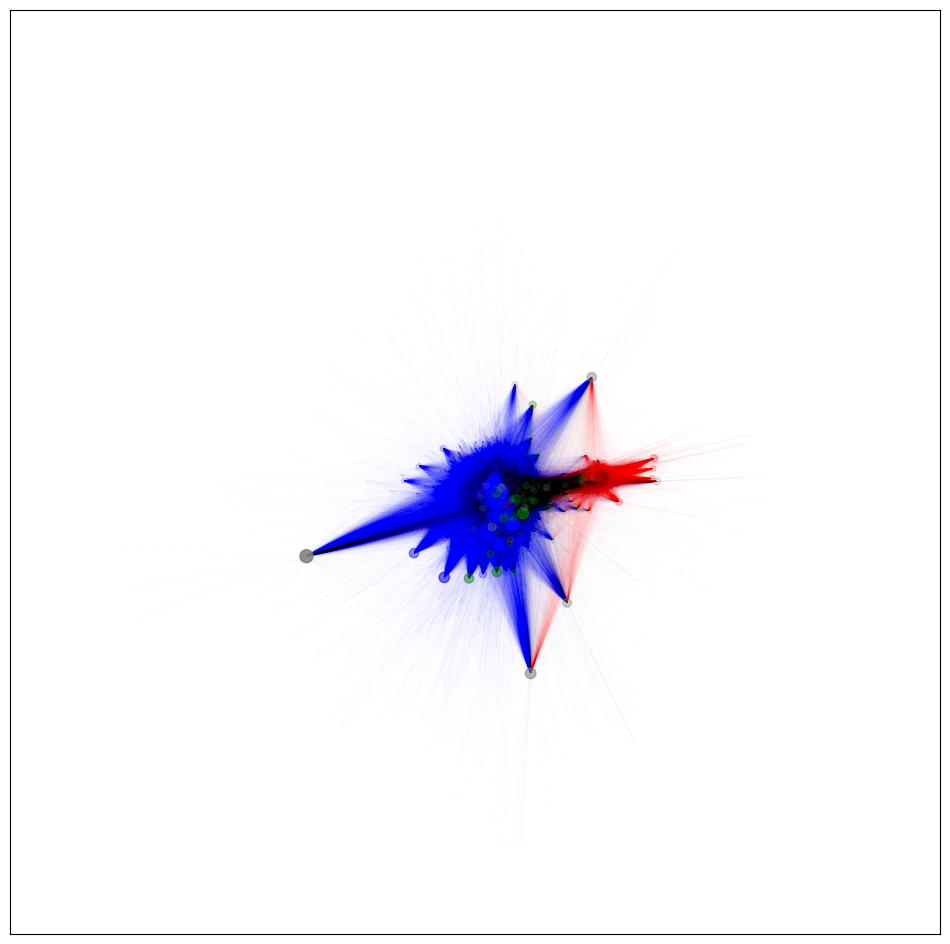

In [22]:
# Color
color_map_dict = {
    'No Retweets': 'gray',
    'Izquierda': 'blue',
    'Derecha': 'red',
    'Centro': 'green'
}
color_map_node = [color_map_dict[subgraph.nodes[node]['Political Label']] for node in subgraph]
color_edge_map = [color_map_dict[subgraph.nodes(data=True)[edge[1]]['Political Label']] for edge in list(subgraph.edges(data=True))]

# Alpha
degrees = dict(subgraph.degree())
max_degree = max(degrees.values())
alpha_values = [(degree / max_degree) for degree in degrees.values()]

# Size
node_degrees = [subgraph.degree(node) * 100 for node in subgraph.nodes()]
def normalize(x, max, min):
    return 100 * ((x - min)/(max - min))
max_deg = max(node_degrees)
min_deg = min(node_degrees)
node_size = list(map(lambda x: normalize(x, max_deg, min_deg), node_degrees))

fig, ax = plt.subplots(figsize = (12,12))

nx.draw_networkx_nodes(subgraph, layout_subgraph, node_color = color_map_node, node_size = node_size, ax = ax, alpha = alpha_values)
nx.draw_networkx_edges(subgraph, layout_subgraph, edge_color=color_edge_map, alpha = 0.003)
plt.show()

## Just Derecha Nodes (no degree scaling for alpha nor size)

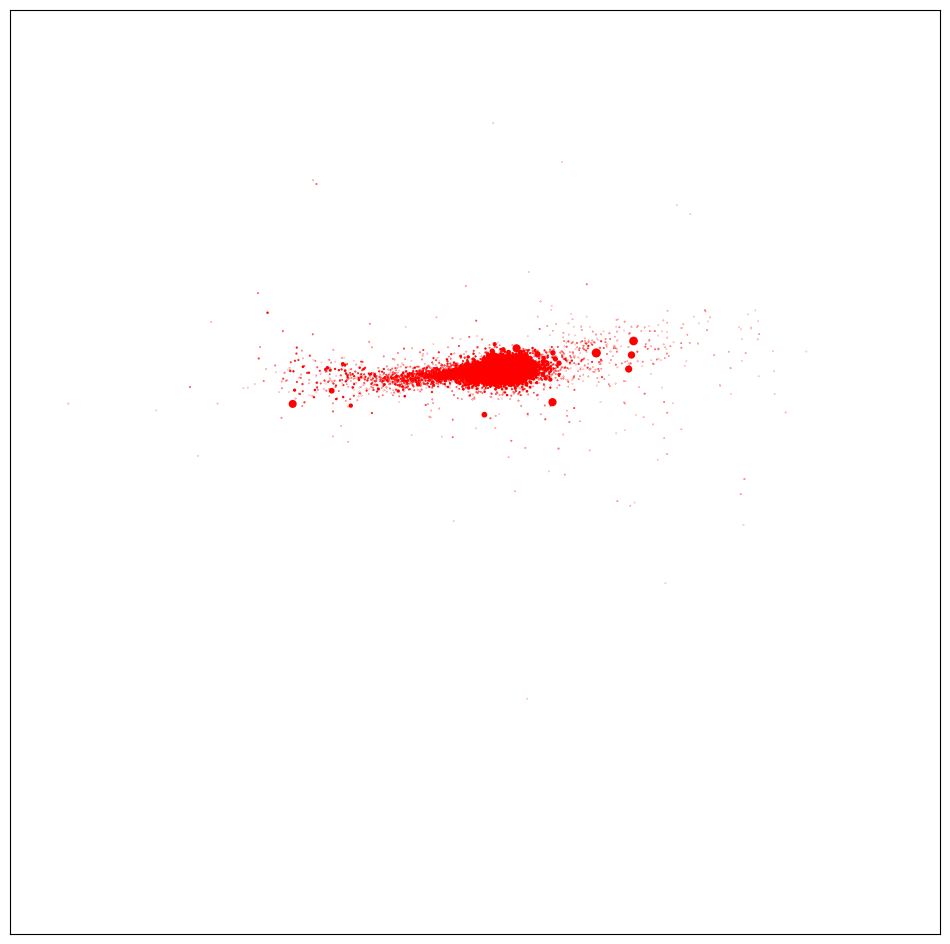

In [23]:
derecha_nodes = [node for node, attrs in subgraph.nodes(data=True) if attrs.get('Political Label') == 'Derecha']

# Color
color_map_dict = {
    'No Retweets': 'gray',
    'Izquierda': 'blue',
    'Derecha': 'red',
    'Centro': 'green'
}
d_color_map_node = [color_map_dict[subgraph.nodes[node]['Political Label']] for node in derecha_nodes]
color_edge_map = [color_map_dict[subgraph.nodes(data=True)[edge[1]]['Political Label']] for edge in list(subgraph.edges(data=True))]

# Alpha
degrees = dict(subgraph.degree())
max_degree = max(degrees.values())
d_alpha_values = [(degree / max_degree) for node, degree in degrees.items() if node in derecha_nodes]

# Size
d_node_degrees = [subgraph.degree(node) * 100 for node in derecha_nodes]
def normalize(x, max, min):
    return 100 * ((x - min)/(max - min))
max_deg = max(node_degrees)
min_deg = min(node_degrees)
d_node_size = list(map(lambda x: normalize(x, max_deg, min_deg), d_node_degrees))

fig, ax = plt.subplots(figsize = (12,12))
nx.draw_networkx_nodes(subgraph, layout_subgraph, nodelist=derecha_nodes, node_color = d_color_map_node, node_size = d_node_size, ax = ax)

## Just Izquierda Nodes (no degree scaling for alpha nor size)

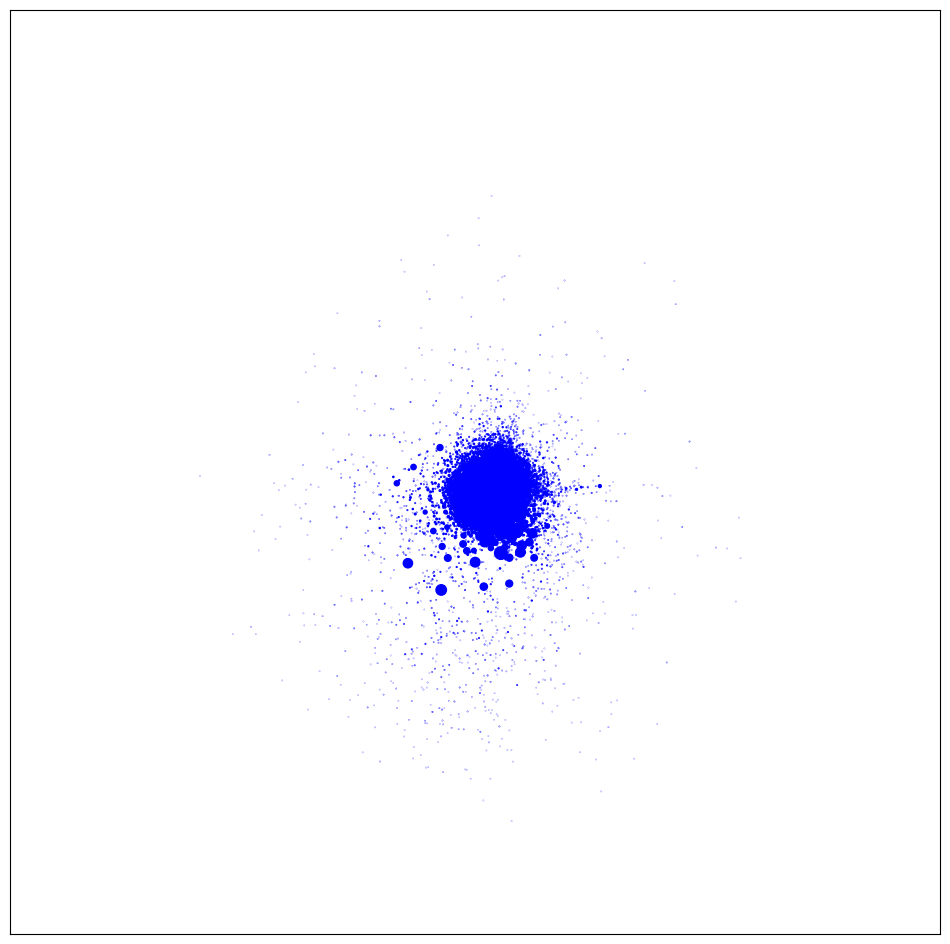

In [24]:
izquierda_nodes = [node for node, attrs in subgraph.nodes(data=True) if attrs.get('Political Label') == 'Izquierda']

# Color
color_map_dict = {
    'No Retweets': 'gray',
    'Izquierda': 'blue',
    'Derecha': 'red',
    'Centro': 'green'
}
i_color_map_node = [color_map_dict[subgraph.nodes[node]['Political Label']] for node in izquierda_nodes]
color_edge_map = [color_map_dict[subgraph.nodes(data=True)[edge[1]]['Political Label']] for edge in list(subgraph.edges(data=True))]

# Alpha
degrees = dict(subgraph.degree())
max_degree = max(degrees.values())
i_alpha_values = [(degree / max_degree) for node, degree in degrees.items() if node in izquierda_nodes]

# Size
i_node_degrees = [subgraph.degree(node) * 100 for node in izquierda_nodes]
def normalize(x, max, min):
    return 100 * ((x - min)/(max - min))
max_deg = max(node_degrees)
min_deg = min(node_degrees)
i_node_size = list(map(lambda x: normalize(x, max_deg, min_deg), i_node_degrees))

fig, ax = plt.subplots(figsize = (12,12))
nx.draw_networkx_nodes(subgraph, layout_subgraph, nodelist=izquierda_nodes, node_color = i_color_map_node, node_size = i_node_size, ax = ax)

## Just Centro Nodes (no degree scaling for alpha nor size)

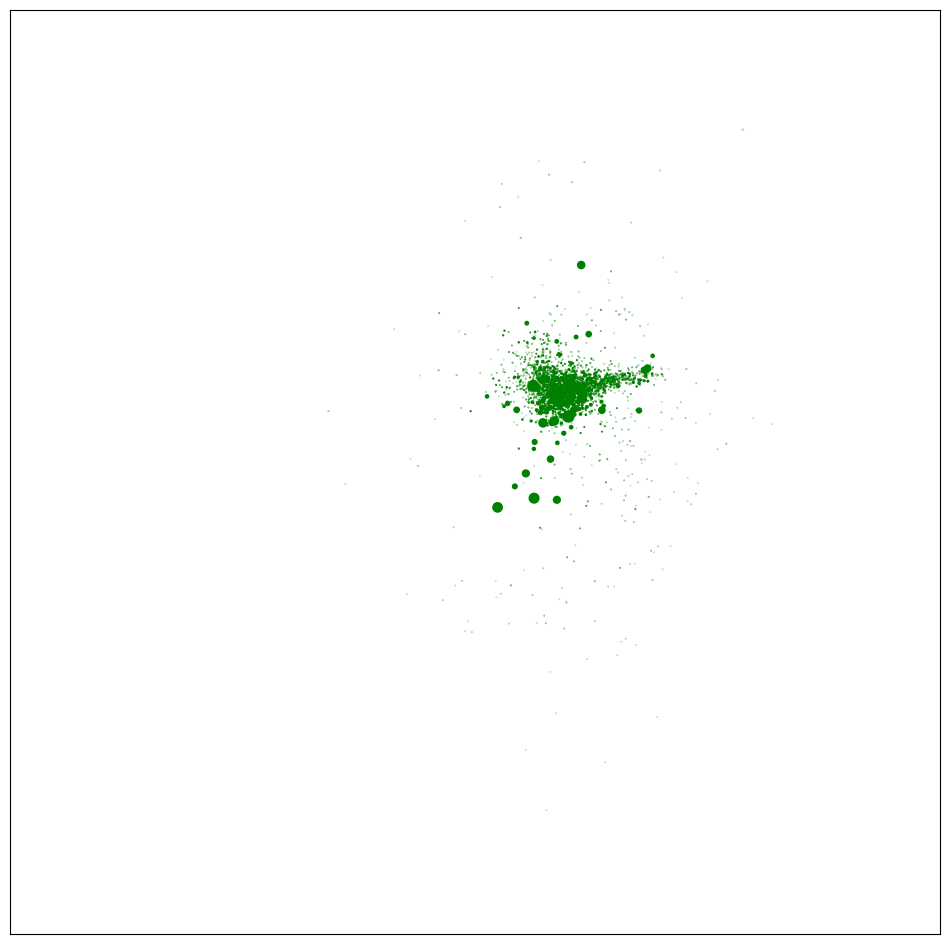

In [25]:
centro_nodes = [node for node, attrs in subgraph.nodes(data=True) if attrs.get('Political Label') == 'Centro']

# Color
color_map_dict = {
    'No Retweets': 'gray',
    'Izquierda': 'blue',
    'Derecha': 'red',
    'Centro': 'green'
}
c_color_map_node = [color_map_dict[subgraph.nodes[node]['Political Label']] for node in centro_nodes]
color_edge_map = [color_map_dict[subgraph.nodes(data=True)[edge[1]]['Political Label']] for edge in list(subgraph.edges(data=True))]

# Alpha
degrees = dict(subgraph.degree())
max_degree = max(degrees.values())
c_alpha_values = [(degree / max_degree) for node, degree in degrees.items() if node in centro_nodes]

# Size
c_node_degrees = [subgraph.degree(node) * 100 for node in centro_nodes]
def normalize(x, max, min):
    return 100 * ((x - min)/(max - min))
max_deg = max(node_degrees)
min_deg = min(node_degrees)
c_node_size = list(map(lambda x: normalize(x, max_deg, min_deg), c_node_degrees))

fig, ax = plt.subplots(figsize = (12,12))
nx.draw_networkx_nodes(subgraph, layout_subgraph, nodelist=centro_nodes, node_color = c_color_map_node, node_size = c_node_size, ax = ax)

## Force Atlas 2 Gephi's Coordinates

### Whole Graph

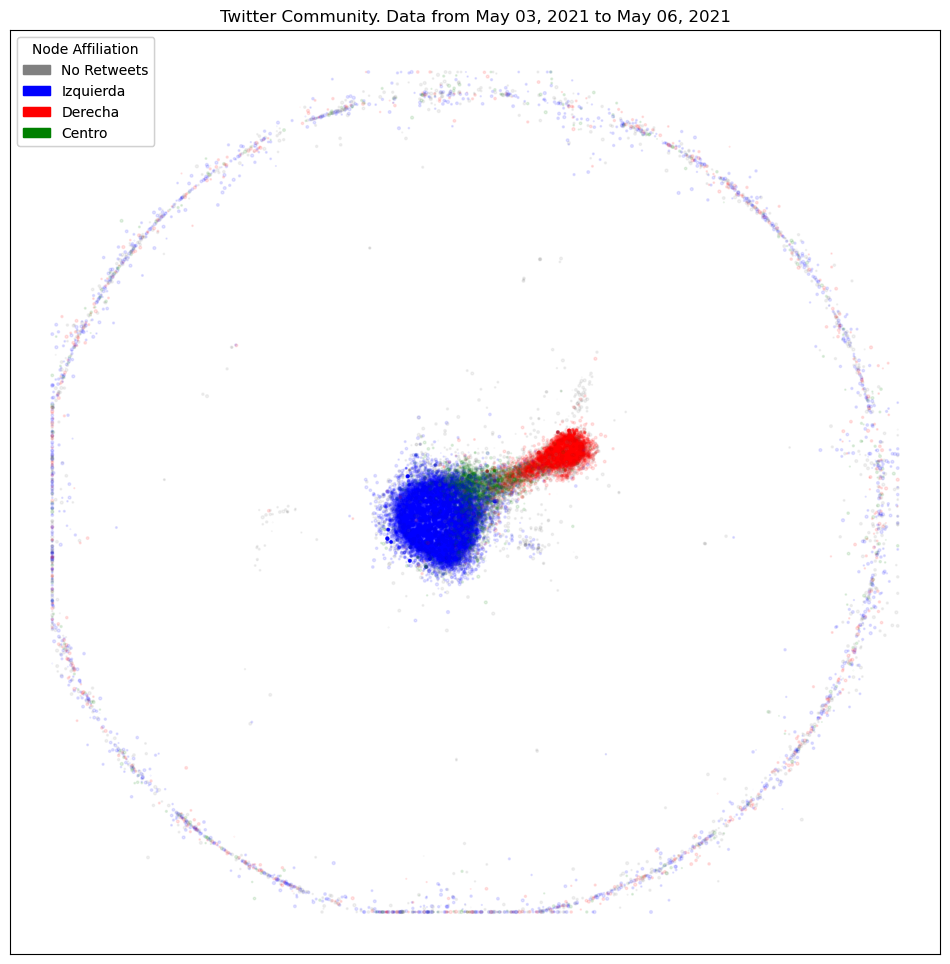

In [73]:
# Color
color_map_dict = {
    'No Retweets': 'gray',
    'Izquierda': 'blue',
    'Derecha': 'red',
    'Centro': 'green'
}
t_color_map_node = [color_map_dict[g_nx.nodes[node]['Political Label']] for node in g_nx.nodes]
color_edge_map = [color_map_dict[g_nx.nodes(data=True)[edge[0]]['Political Label']] for edge in list(g_nx.edges(data=True))]

# Alpha
degrees = dict(g_nx.degree())
max_degree = max(degrees.values())
t_alpha_values = [(degree / max_degree) for node, degree in degrees.items() if node in g_nx.nodes]

# Size
t_node_degrees = [g_nx.degree(node) * 200 for node in g_nx.nodes]
def normalize(x, max, min):
    return 100 * ((x - min)/(max - min))
max_deg = max(node_degrees)
min_deg = min(node_degrees)
t_node_size = list(map(lambda x: normalize(x, max_deg, min_deg), g_nx.nodes))

fig, ax = plt.subplots(figsize = (12,12))
# Create a legend for node colors
node_legend = [mpatches.Patch(color=color, label=label) for label, color in color_map_dict.items()]
node_legend_title = 'Node Affiliation'
node_legend_handle = plt.legend(handles=node_legend, title=node_legend_title, loc='upper left')

starting_date_obj = datetime.strptime(date, '%Y-%m-%d')
formatted_starting = starting_date_obj.strftime('%B %d, %Y')
ending_date_obj = starting_date_obj + timedelta(days=3)
formatted_ending = ending_date_obj.strftime('%B %d, %Y')

ax.add_artist(node_legend_handle)

plt.title(f"Twitter Community. Data from {formatted_starting} to {formatted_ending}")
nx.draw_networkx_nodes(g_nx, gephi_pos, node_color = t_color_map_node, node_size = t_node_size, ax = ax, alpha=0.1)
plt.show()

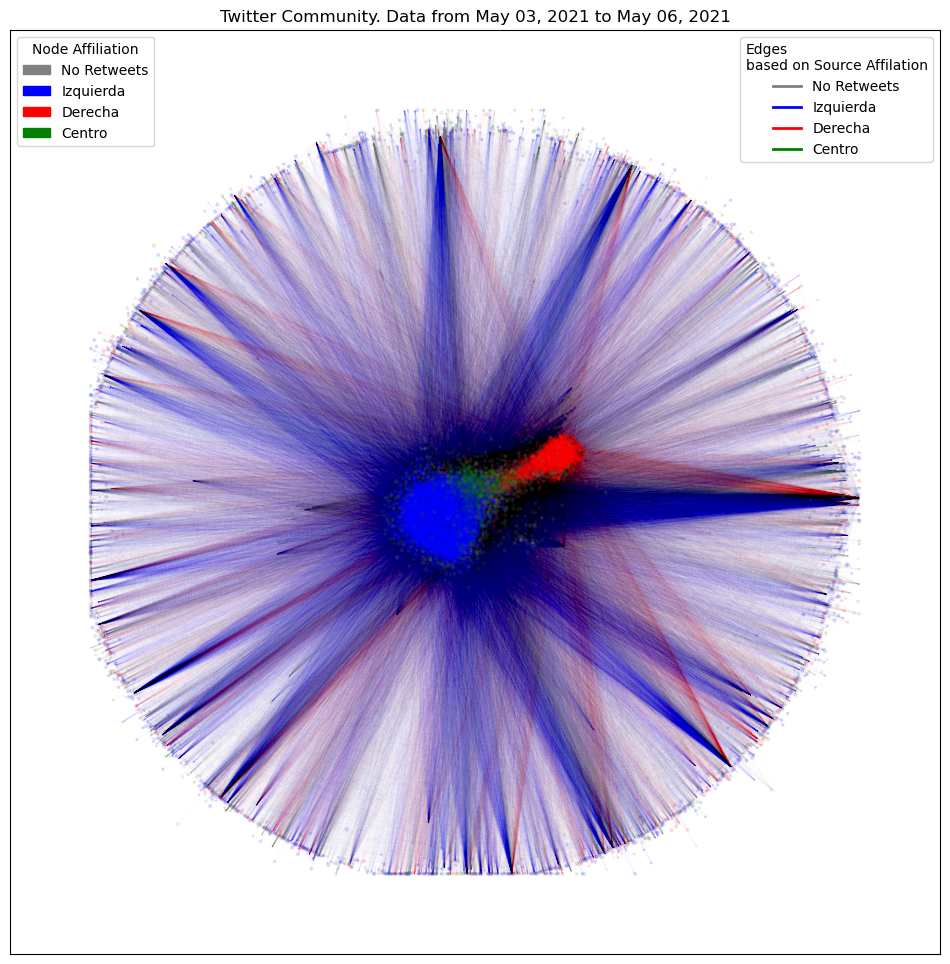

In [70]:
# Color
color_map_dict = {
    'No Retweets': 'gray',
    'Izquierda': 'blue',
    'Derecha': 'red',
    'Centro': 'green'
}
t_color_map_node = [color_map_dict[g_nx.nodes[node]['Political Label']] for node in g_nx.nodes]
color_edge_map = [color_map_dict[g_nx.nodes(data=True)[edge[1]]['Political Label']] for edge in list(g_nx.edges(data=True))]

# Alpha
degrees = dict(g_nx.degree())
max_degree = max(degrees.values())
t_alpha_values = [(degree / max_degree) for node, degree in degrees.items() if node in g_nx.nodes]

# Size
t_node_degrees = [g_nx.degree(node) * 200 for node in g_nx.nodes]
def normalize(x, max, min):
    return 100 * ((x - min)/(max - min))
max_deg = max(node_degrees)
min_deg = min(node_degrees)
t_node_size = list(map(lambda x: normalize(x, max_deg, min_deg), g_nx.nodes))

fig, ax = plt.subplots(figsize = (12,12))
nx.draw_networkx_nodes(g_nx, gephi_pos, node_color = t_color_map_node, node_size = t_node_size, ax = ax, alpha=0.1)
nx.draw_networkx_edges(g_nx, gephi_pos, edge_color=color_edge_map, alpha = 0.002)


# Create a legend for node colors
node_legend = [mpatches.Patch(color=color, label=label) for label, color in color_map_dict.items()]
node_legend_title = 'Node Affiliation'
node_legend_handle = plt.legend(handles=node_legend, title=node_legend_title, loc='upper left')

# Create a legend for edge colors
edge_legend = [mlines.Line2D([0], [0], color=color, label=label, linewidth=2) for label, color in color_map_dict.items()]
edge_legend_title = 'Edges\nbased on Source Affilation'
edge_legend_handle = plt.legend(handles=edge_legend, title=edge_legend_title, alignment= 'center', loc='upper right')

# Add the legends to the plot
ax.add_artist(node_legend_handle)

# Title
starting_date_obj = datetime.strptime(date, '%Y-%m-%d')
formatted_starting = starting_date_obj.strftime('%B %d, %Y')
ending_date_obj = starting_date_obj + timedelta(days=3)
formatted_ending = ending_date_obj.strftime('%B %d, %Y')


plt.title(f"Twitter Community. Data from {formatted_starting} to {formatted_ending}")
plt.show()